# Research Matrix Completion Benchmarking

## Alfredo de la Fuente / Maria Burkina

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import hstack
import pickle
import pywFM
import sys,os,os.path
os.environ['LIBFM_PATH']=os.path.expanduser('/home/alfredo/libfm/bin/')

### Data
The data consists of:
1. sample_ids_filtered.txt - the list of ids of species of tuberculosis
2. drug_features_final.csv - literally drug features, rows contain names of features and values, columns correspond to drugs
3. all_snp_list_filtered2.csv - all the mutations in species. Each row - some mutation. This file is needed for convenience for us to know in advance the whole list of mutations and know the size of feature vector. Currently we have  171 000 mutations.
4. phenotype_filtered.csv - describes sustainability of species from sample_ids_filtered.txt к with respect to drugs from drug_features_final.csv. We need to estimate unknown elements of this matrix There are 4 possible values: S - sensitive, R - resistent, '-' - no data, M -something in between. We will restrict ourselves to the classification task based only in the S and R categories.
5. annotated.tar.gz - the archive where for each id from sample_ids_filtered.txt we have a text file containing the lines with mutations from all_snp_list_filtered2.csv, meaning that for this id this binary feature is equal to 1.

#### Observations:
- Due to memory limitations, we will need to work with sparse format of the matrices during the whole process.
- The data from the annotaed.tar.gz has already been preprocessed by Maria Burkina and stored at the files "sample_feature_table" and "sample_feature_encoding".

### Preprocessing

In [20]:
# Sample - Drug Matrix ( 4815 x 13 )
R = pd.read_csv("MTB_data/phenotype_filtered.csv")
R

,Organism_name,Isoniazid,Rifampicin,Ethambutol,Pyrazinamide,Streptomycin,Ciprofloxacin,Moxifloxacin,Ofloxacin,Amikacin,Capreomycin,Kanamycin,Prothionamide,Ethionamide
0,SAMEA961610,S,S,S,S,-,-,-,-,-,-,-,-,-
1,SAMEA961608,S,S,S,S,-,-,-,-,-,-,-,-,-
2,SAMEA961609,S,S,S,S,-,-,-,-,-,-,-,-,-
3,SAMEA961584,S,S,S,S,-,-,-,-,-,-,-,-,-
4,SAMEA961583,S,S,S,S,-,-,-,-,-,-,-,-,-
5,SAMEA961582,S,S,S,S,-,-,-,-,-,-,-,-,-
6,SAMEA961581,S,S,S,S,-,-,-,-,-,-,-,-,-
7,SAMEA961587,S,S,S,S,-,-,-,-,-,-,-,-,-
8,SAMEA961586,S,S,S,S,-,-,-,-,-,-,-,-,-
9,SAMEA961585,S,S,S,S,S,S,-,-,-,-,-,-,-


In [5]:
# Only take the R and S for binary classification
row_y = []
col_y = []
data_y = []
for j in range(len(drugs)):
    for i in range(len(R)):
        if (R.iloc[i][1+j] == 'R'):
            row_y.append(i)
            col_y.append(j)
            data_y.append(1.0)
        elif (R.iloc[i][1+j] == 'S'):
            row_y.append(i)
            col_y.append(j)
            data_y.append(-1.0)

In [21]:
#User precomputed features by accessing to annotations file
# Sample features ( 4815 x 171810 )
with open ('sample_feature_table', 'rb') as fp:
    sample_feature_table = pickle.load(fp)
with open ('sample_feature_encoding', 'rb') as fp:
    le = pickle.load(fp)

row_not_flatten = [i*np.ones(len(sample_feature_table[i])) for i in range(len(sample_feature_table))]
row = [row_not_flatten[i][j] for i in range(len(sample_feature_table)) for j in range(len(sample_feature_table[i]))]
col = [sample_feature_table[i][j] for i in range(len(sample_feature_table)) for j in range(len(sample_feature_table[i]))]
X1 = scipy.sparse.csc_matrix((np.ones(len(col)), (row, col)), shape=(len(sample_feature_table), len(le.classes_)))

/home/alfredo/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [5]:
# Drug Features ( 13 x 28 )
X2 = pd.read_csv("MTB_data/drug_features_final.csv")
drugs = X2.columns[1:]
X2 = np.transpose(X2[drugs])
X2 = np.array(X2, dtype=np.float)
print(X2)
X2 = scipy.sparse.csc_matrix(X2)

[[1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1.
  0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0.
  0. 0. 0. 1.]
 [0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0.
  0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.
  0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1.
  1. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0.
  1. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0.
  0. 1. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0.
  0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
  0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0

### Modeling

We prepare the spliting in order to assess accuracy of different models consistently. 

In [23]:
# Split Routine - per drug
n_splits = 2
train_test_indexes = [[None, None] for iterator in range(n_splits)] #n_splits arrays consist of [train_indexes, test_indexes]
drug_idx_list = [[0] for iterator in range(n_splits)] #array needed for estimation the prediction on particular drugs
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.5, random_state=14)

shift = 0

count = 0
drug_col = R[R.columns[1]]
drug_col = drug_col.map({'S':-1.0, 'R':1.0})
drug_col = drug_col.dropna()
for train_index, test_index in sss.split(np.zeros(len(drug_col)), drug_col):
            train_test_indexes[count][0] = train_index.tolist()
            train_test_indexes[count][1] = test_index.tolist()
            drug_idx_list[count].append(drug_idx_list[count][-1] + len(test_index))
            count += 1
shift += len(drug_col)

for item in R.columns[2:]:
    drug_col = R[item]
    drug_col = drug_col.map({'S':-1.0, 'R':1.0})
    drug_col = drug_col.dropna()
    count = 0
    for train_index, test_index in sss.split(np.zeros(len(drug_col)), drug_col):
        train_test_indexes[count][0].extend( (train_index+shift).tolist())
        train_test_indexes[count][1].extend( (test_index+shift).tolist())
        drug_idx_list[count].append(drug_idx_list[count][-1] + len(test_index))
        count += 1
    shift += len(drug_col)        

### Model 1 - LibFM ( pywFM ) - Without Side Information

We will use a Factorization Machine python wrapper implementation https://github.com/jfloff/pywFM that uses the original library of FM https://github.com/srendle/libfm . We will approach two cases for the method: regression with sign function on top and classification. 

In [24]:
# OneHotEncoder
paired_data = np.column_stack((row_y, col_y))
enc = OneHotEncoder()
enc.fit(paired_data)

#Store results
results_model_1 = [[] for _ in range(n_splits)]

#For different splits of data
for i in range(n_splits):
    
    train_index = train_test_indexes[i][0]
    test_index = train_test_indexes[i][1]
    
    y_train = np.asarray( [data_y[iterator] for iterator in train_index] )
    y_test = np.asarray( [data_y[iterator] for iterator in test_index] )
    
    # Give the required format - OneHotEncoding
    train_row_y = [row_y[iterator] for iterator in train_index]
    train_col_y = [col_y[iterator] for iterator in train_index]
    X_train = enc.transform( np.column_stack((train_row_y, train_col_y)) )
    

    test_row_y = [row_y[iterator] for iterator in test_index]
    test_col_y = [col_y[iterator] for iterator in test_index]
    X_test = enc.transform( np.column_stack((test_row_y, test_col_y)) )
    
    # Train model
    fm = pywFM.FM(task='classification', num_iter=1000)    
    model = fm.run(X_train, y_train, X_test, y_test ) #No Predict Function implemented
    
    pred_proba = model.predictions

    # Evaluate predictions
    y_pred = np.sign( np.asarray(pred_proba) - 0.5 )
    
    #Store 
    results_model_1[i].append(recall_score(y_test, y_pred))
    results_model_1[i].append(precision_score(y_test, y_pred))
    results_model_1[i].append(accuracy_score(y_test, y_pred))
    results_model_1[i].append(f1_score(y_test, y_pred))
    results_model_1[i].append(roc_auc_score(y_test, pred_proba))
    
    # Report
    print("\nOverall metrics:")
    
    print('Recall: ' , recall_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('F1 Score: ', f1_score(y_test, y_pred))
    print('ROC-AUC score ', roc_auc_score(y_test, pred_proba ))
    
    print('\nReport per Drug')
    for j in range(len(drug_idx_list[i])-1):
        print ("\n",drugs[j])
        Y_true_drug = y_test[drug_idx_list[i][j]:drug_idx_list[i][j+1]]
        Y_pred_drug = y_pred[drug_idx_list[i][j]:drug_idx_list[i][j+1]]
        
        #Store
        results_model_1[i].append(recall_score(Y_true_drug, Y_pred_drug))
        results_model_1[i].append(precision_score(Y_true_drug, Y_pred_drug))
        results_model_1[i].append(accuracy_score(Y_true_drug, Y_pred_drug))
        results_model_1[i].append(f1_score(Y_true_drug, Y_pred_drug))

        #Report 
        print("Recall: ",recall_score(Y_true_drug, Y_pred_drug))
        print("Precision: ", precision_score(Y_true_drug, Y_pred_drug))
        print("Accuracy: ", accuracy_score(Y_true_drug, Y_pred_drug))
        print("F1-score: ", f1_score(Y_true_drug, Y_pred_drug))
    count += 1
    print(' ')


Overall metrics:
Recall:  0.5262165220671444
Precision:  0.8035714285714286
Accuracy:  0.8865202870745399
F1 Score:  0.6359699111009801
ROC-AUC score  0.8899235105262855

Report per Drug

 Isoniazid
Recall:  0.6327433628318584
Precision:  0.9166666666666666
Accuracy:  0.8774468085106383
F1-score:  0.7486910994764399

 Rifampicin
Recall:  0.6404040404040404
Precision:  0.8498659517426274
Accuracy:  0.8997858672376874
F1-score:  0.7304147465437788

 Ethambutol
Recall:  0.40939597315436244
Precision:  0.7218934911242604
Accuracy:  0.9049445865302643
F1-score:  0.5224839400428266

 Pyrazinamide
Recall:  0.20465116279069767
Precision:  0.5057471264367817
Accuracy:  0.9046345811051694
F1-score:  0.2913907284768212

 Streptomycin
Recall:  0.728515625
Precision:  0.8574712643678161
Accuracy:  0.8714011516314779
F1-score:  0.7877507919746568

 Ciprofloxacin
Recall:  0.16666666666666666
Precision:  0.2857142857142857
Accuracy:  0.9079754601226994
F1-score:  0.2105263157894737

 Moxifloxacin
Rec

### Model 2 - pylibFM Library - Without Side Information

We will use a Factorization Machine python library https://github.com/coreylynch/pyFM . Just for testing purposes, we will consider a classification problem
    


In [142]:
from pyfm import pylibfm


#For different splits of data
for i in range(n_splits):
    
    train_index = train_test_indexes[i][0]
    test_index = train_test_indexes[i][1]
    
    y_train = np.asarray( [data_y[iterator] for iterator in train_index] )
    y_test = np.asarray( [data_y[iterator] for iterator in test_index] )
    
    train_data = [] 
    for j in train_index :
        train_data.append({ "row": row_y[j], "col": col_y[j] })
        
    test_data = []
    for j in test_index :
        test_data.append({ "row": row_y[j], "col": col_y[j] })
    
    # Give the required format
    v = DictVectorizer()
    X_train = v.fit_transform(train_data)
    X_test = v.transform(test_data)
    
    # Train model
    fm = pylibfm.FM(num_factors=50, num_iter=100, verbose=False, task="classification", \
                    initial_learning_rate=0.00001, learning_rate_schedule="optimal")
    
    fm.fit(X_train,y_train)
    
    # Evaluate predictions
    pred_proba = fm.predict(X_test)
    y_pred = np.sign( pred_proba - 0.5 )
    
    print("\nOverall metrics:")
    print('Recall: ' , recall_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('F1 Score: ', f1_score(y_test, y_pred))
    print('ROC-AUC score ', roc_auc_score(y_test, pred_proba ))
    
    print('\nReport per Drug')
    for j in range(len(drug_idx_list[i])-1):
        print ("\n",drugs[j])
        Y_true_drug = y_test[drug_idx_list[i][j]:drug_idx_list[i][j+1]]
        Y_pred_drug = y_pred[drug_idx_list[i][j]:drug_idx_list[i][j+1]]
        print("Recall: ",recall_score(Y_true_drug, Y_pred_drug))
        print("Precision: ", precision_score(Y_true_drug, Y_pred_drug))
        print("Accuracy: ", accuracy_score(Y_true_drug, Y_pred_drug))
        print("F1-score: ", f1_score(Y_true_drug, Y_pred_drug))
    count += 1
    print(' ')


Overall metrics:
Recall:  0.0015088645794
Precision:  0.020618556701
Accuracy:  0.798408299581
F1 Score:  0.00281195079086
ROC-AUC score  0.623114175223

Report per Drug

 Isoniazid
Recall:  0.0
Precision:  0.0
Accuracy:  0.703829787234
F1-score:  0.0

 Rifampicin
Recall:  0.0
Precision:  0.0
Accuracy:  0.773447537473
F1-score:  0.0

 Ethambutol
Recall:  0.0
Precision:  0.0
Accuracy:  0.852088661552
F1-score:  0.0

 Pyrazinamide
Recall:  0.0046511627907
Precision:  0.016393442623
Accuracy:  0.877896613191
F1-score:  0.00724637681159

 Streptomycin
Recall:  0.0
Precision:  0.0
Accuracy:  0.66474728087
F1-score:  0.0

 Ciprofloxacin
Recall:  0.166666666667
Precision:  0.222222222222
Accuracy:  0.895705521472
F1-score:  0.190476190476

 Moxifloxacin
Recall:  0.015625
Precision:  1.0
Accuracy:  0.865096359743
F1-score:  0.0307692307692

 Ofloxacin
Recall:  0.0
Precision:  0.0
Accuracy:  0.851094890511
F1-score:  0.0

 Amikacin
Recall:  0.0
Precision:  0.0
Accuracy:  0.884808013356
F1-scor

/home/alfredo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/alfredo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Overall metrics:
Recall:  1.0
Precision:  0.188374902295
Accuracy:  0.188374902295
F1 Score:  0.317029418799
ROC-AUC score  0.411158712091

Report per Drug

 Isoniazid
Recall:  1.0
Precision:  0.288510638298
Accuracy:  0.288510638298
F1-score:  0.447820343461

 Rifampicin
Recall:  1.0
Precision:  0.21199143469
Accuracy:  0.21199143469
F1-score:  0.349823321555

 Ethambutol
Recall:  1.0
Precision:  0.127024722933
Accuracy:  0.127024722933
F1-score:  0.225416036309

 Pyrazinamide
Recall:  1.0
Precision:  0.0958110516934
Accuracy:  0.0958110516934
F1-score:  0.174867832452

 Streptomycin
Recall:  1.0
Precision:  0.327575175944
Accuracy:  0.327575175944
F1-score:  0.493493975904

 Ciprofloxacin
Recall:  1.0
Precision:  0.0736196319018
Accuracy:  0.0736196319018
F1-score:  0.137142857143

 Moxifloxacin
Recall:  1.0
Precision:  0.13704496788
Accuracy:  0.13704496788
F1-score:  0.241054613936

 Ofloxacin
Recall:  1.0
Precision:  0.148905109489
Accuracy:  0.148905109489
F1-score:  0.259212198

### Model 3 - LibFM ( pywFM ) - Drug Side Information

We will use a Factorization Machine python wrapper implementation https://github.com/jfloff/pywFM that uses the original library of FM https://github.com/srendle/libfm . We will approach two cases for the method: regression with sign function on top and classification. 

In [26]:
#Store results
results_model_2 = [[] for _ in range(n_splits)]

#For different splits of data
for i in range(n_splits):
    
    train_index = train_test_indexes[i][0]
    test_index = train_test_indexes[i][1]
    
    y_train = np.asarray( [data_y[iterator] for iterator in train_index] )
    y_test = np.asarray( [data_y[iterator] for iterator in test_index] )
    
    # Give the required format - OneHotEncoding
    train_row_y = [row_y[iterator] for iterator in train_index]
    train_col_y = [col_y[iterator] for iterator in train_index]
    X_train = enc.transform( np.column_stack((train_row_y, train_col_y)) )
    X_train = hstack( ( X_train , X2[train_col_y,:] ) ) # Side Information
    

    test_row_y = [row_y[iterator] for iterator in test_index]
    test_col_y = [col_y[iterator] for iterator in test_index]
    X_test = enc.transform( np.column_stack((test_row_y, test_col_y)) )
    X_test = hstack( ( X_test , X2[test_col_y,:] ) ) # Side Information
    
    # Train model
    fm = pywFM.FM(task='classification', num_iter=1000)    
    model = fm.run(X_train, y_train, X_test, y_test ) #No Predict Function implemented
    
    pred_proba = model.predictions

    # Evaluate predictions
    y_pred = np.sign( np.asarray(pred_proba) - 0.5 )
    
    #Store 
    results_model_2[i].append(recall_score(y_test, y_pred))
    results_model_2[i].append(precision_score(y_test, y_pred))
    results_model_2[i].append(accuracy_score(y_test, y_pred))
    results_model_2[i].append(f1_score(y_test, y_pred))
    results_model_2[i].append(roc_auc_score(y_test, pred_proba))
    
    print("\nOverall metrics:")
    print('Recall: ' , recall_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('F1 Score: ', f1_score(y_test, y_pred))
    print('ROC-AUC score ', roc_auc_score(y_test, pred_proba ))
    
    print('\nReport per Drug')
    for j in range(len(drug_idx_list[i])-1):
        print ("\n",drugs[j])
        Y_true_drug = y_test[drug_idx_list[i][j]:drug_idx_list[i][j+1]]
        Y_pred_drug = y_pred[drug_idx_list[i][j]:drug_idx_list[i][j+1]]
        
        #Store
        results_model_2[i].append(recall_score(Y_true_drug, Y_pred_drug))
        results_model_2[i].append(precision_score(Y_true_drug, Y_pred_drug))
        results_model_2[i].append(accuracy_score(Y_true_drug, Y_pred_drug))
        results_model_2[i].append(f1_score(Y_true_drug, Y_pred_drug))
        
        print("Recall: ",recall_score(Y_true_drug, Y_pred_drug))
        print("Precision: ", precision_score(Y_true_drug, Y_pred_drug))
        print("Accuracy: ", accuracy_score(Y_true_drug, Y_pred_drug))
        print("F1-score: ", f1_score(Y_true_drug, Y_pred_drug))
        
    count += 1
    print(' ')


Overall metrics:
Recall:  0.5190494153149755
Precision:  0.8161328588374852
Accuracy:  0.8873729837277056
F1 Score:  0.6345400046114826
ROC-AUC score  0.8942280414595616

Report per Drug

 Isoniazid
Recall:  0.6224188790560472
Precision:  0.9295154185022027
Accuracy:  0.8774468085106383
F1-score:  0.745583038869258

 Rifampicin
Recall:  0.6666666666666666
Precision:  0.8270676691729323
Accuracy:  0.8997858672376874
F1-score:  0.738255033557047

 Ethambutol
Recall:  0.3926174496644295
Precision:  0.6647727272727273
Accuracy:  0.8976982097186701
F1-score:  0.49367088607594944

 Pyrazinamide
Recall:  0.16279069767441862
Precision:  0.49295774647887325
Accuracy:  0.9037433155080213
F1-score:  0.24475524475524477

 Streptomycin
Recall:  0.720703125
Precision:  0.8621495327102804
Accuracy:  0.8707613563659629
F1-score:  0.7851063829787234

 Ciprofloxacin
Recall:  0.08333333333333333
Precision:  0.5
Accuracy:  0.9263803680981595
F1-score:  0.14285714285714285

 Moxifloxacin
Recall:  0.265625

### Model 4 - LibFM ( pywFM ) - Drug & Sample  Side Information

We will use a Factorization Machine python wrapper implementation https://github.com/jfloff/pywFM that uses the original library of FM https://github.com/srendle/libfm . We will approach two cases for the method: regression with sign function on top and classification. 

In [194]:
#Store results
results_model_3 = [[] for _ in range(n_splits)]

#For different splits of data
for i in range(n_splits):
    
    train_index = train_test_indexes[i][0]
    test_index = train_test_indexes[i][1]
    
    y_train = np.asarray( [data_y[iterator] for iterator in train_index] )
    y_test = np.asarray( [data_y[iterator] for iterator in test_index] )
    
    # Give the required format - OneHotEncoding
    train_row_y = [row_y[iterator] for iterator in train_index]
    train_col_y = [col_y[iterator] for iterator in train_index]
    X_train = enc.transform( np.column_stack((train_row_y, train_col_y)) )
    X_train = hstack( ( X_train , X2[train_col_y,:], X1[train_row_y,:] ) ) # Side Information
    

    test_row_y = [row_y[iterator] for iterator in test_index]
    test_col_y = [col_y[iterator] for iterator in test_index]
    X_test = enc.transform( np.column_stack((test_row_y, test_col_y)) )
    X_test = hstack( ( X_test , X2[test_col_y,:], X1[test_row_y,:] ) ) # Side Information
    
    # Train model
    fm = pywFM.FM(task='classification', num_iter=150)    
    model = fm.run(X_train, y_train, X_test, y_test ) #No Predict Function implemented
    
    pred_proba = model.predictions
    
    # Evaluate predictions
    y_pred = np.sign( np.asarray(pred_proba) - 0.5 )
    
    #Store 
    results_model_3[i].append(recall_score(y_test, y_pred))
    results_model_3[i].append(precision_score(y_test, y_pred))
    results_model_3[i].append(accuracy_score(y_test, y_pred))
    results_model_3[i].append(f1_score(y_test, y_pred))
    results_model_3[i].append(roc_auc_score(y_test, pred_proba))
    
    print("\nOverall metrics:")
    print('Recall: ' , recall_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('F1 Score: ', f1_score(y_test, y_pred))
    print('ROC-AUC score ', roc_auc_score(y_test, pred_proba ))
    
    print('\nReport per Drug')
    for j in range(len(drug_idx_list[i])-1):
        print ("\n",drugs[j])
        Y_true_drug = y_test[drug_idx_list[i][j]:drug_idx_list[i][j+1]]
        Y_pred_drug = y_pred[drug_idx_list[i][j]:drug_idx_list[i][j+1]]
        
        #Store
        results_model_3[i].append(recall_score(Y_true_drug, Y_pred_drug))
        results_model_3[i].append(precision_score(Y_true_drug, Y_pred_drug))
        results_model_3[i].append(accuracy_score(Y_true_drug, Y_pred_drug))
        results_model_3[i].append(f1_score(Y_true_drug, Y_pred_drug))
        
        print("Recall: ",recall_score(Y_true_drug, Y_pred_drug))
        print("Precision: ", precision_score(Y_true_drug, Y_pred_drug))
        print("Accuracy: ", accuracy_score(Y_true_drug, Y_pred_drug))
        print("F1-score: ", f1_score(Y_true_drug, Y_pred_drug))
    count += 1
    print(' ')


Overall metrics:
Recall:  0.6680497925311203
Precision:  0.7472573839662447
Accuracy:  0.8949051374973354
F1 Score:  0.7054371639115714
ROC-AUC score  0.9112460973056489

Report per Drug

 Isoniazid
Recall:  0.7507374631268436
Precision:  0.8961267605633803
Accuracy:  0.9029787234042553
F1-score:  0.8170144462279293

 Rifampicin
Recall:  0.8202020202020202
Precision:  0.8565400843881856
Accuracy:  0.932762312633833
F1-score:  0.8379772961816305

 Ethambutol
Recall:  0.6208053691275168
Precision:  0.6187290969899666
Accuracy:  0.9032395566922421
F1-score:  0.6197654941373535

 Pyrazinamide
Recall:  0.3953488372093023
Precision:  0.4336734693877551
Accuracy:  0.892602495543672
F1-score:  0.413625304136253

 Streptomycin
Recall:  0.822265625
Precision:  0.8734439834024896
Accuracy:  0.9027511196417146
F1-score:  0.8470824949698189

 Ciprofloxacin
Recall:  0.5833333333333334
Precision:  0.35
Accuracy:  0.8895705521472392
F1-score:  0.4375

 Moxifloxacin
Recall:  0.359375
Precision:  0.489

In [195]:
with open('results.pkl', 'wb') as f: 
    pickle.dump([results_model_1, results_model_2, results_model_3], f)

In [2]:
with open ('results.pkl', 'rb') as f:
    results_model_1, results_model_2, results_model_3 = pickle.load(f)

## Report Results

In [3]:
## Overall results

#Alfredo
r1 = np.mean ( np.asarray( results_model_1 ) , axis = 0 )
r2 = np.mean ( np.asarray( results_model_2 ) , axis = 0 )
r3 = np.mean ( np.asarray( results_model_3 ) , axis = 0 )

#Maria
r4 = np.load('overall_rec_prec_acc.npy')
r4 = np.append( r4 , ( 2.*r4[0]*r4[1] ) / ( r4[0]+r4[1]) )
r4 = np.asarray( np.append( r4, np.NaN) )

#Report results
overall_results = pd.DataFrame(data = np.vstack( ( r1[0:5] , r2[0:5] , r3[0:5], r4[0:5]) ) , \
                               index = ['FM', 'FM-Drug', 'FM-Side', 'IMC'], \
                               columns = ['Recall', 'Precision', 'Accuracy', 'F1-score', 'ROC-AUC'])

overall_results

,Recall,Precision,Accuracy,F1-score,ROC-AUC
FM,0.525651,0.808090,0.887124,0.636958,0.894166
FM-Drug,0.531309,0.814899,0.888972,0.643141,0.896595
FM-Side,0.673897,0.730885,0.891708,0.701066,0.909169
IMC,0.708035,0.723077,0.893910,0.715477,NaN


In [6]:
# Per Drug results 

arrays = [ 4*['FM'] + 4*['FM-Drug'] + 4*['FM-Side'] + 4*['IMC'] ,\
           4*['Recall', 'Precision', 'Accuracy', 'F1-score']]

tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=['Model', 'Metrics'])

r4 = np.load('per_drug_rec_prec_acc.npy')
r4 = np.column_stack( ( r4, scipy.stats.hmean(r4[:,0:2], axis = 1)) )
    
drug_results = pd.DataFrame(data = np.hstack( ( r1[5:].reshape((-1,4)) , r2[5:].reshape((-1,4)), \
                                               r3[5:].reshape((-1,4)) , r4 ) ).T , \
                          index = index , \
                          columns = np.asarray(drugs))

cm = sns.light_palette("green", as_cmap=True)
drug_results.style.format("{:.2%}")
drug_results.style.background_gradient(cmap=cm)
drug_results

Isoniazid  Rifampicin  Ethambutol  Pyrazinamide  \
Model   Metrics                                                      
FM      Recall      0.639381    0.646465    0.365772      0.190698   
        Precision   0.908025    0.853315    0.694280      0.493380   
        Accuracy    0.877234    0.901499    0.899190      0.903743   
        F1-score    0.750311    0.735620    0.478437      0.274947   
FM-Drug Recall      0.632006    0.674747    0.380872      0.174419   
        Precision   0.916003    0.834980    0.661728      0.493392   
        Accuracy    0.877021    0.902784    0.896633      0.903743   
        F1-score    0.747792    0.746360    0.483395      0.257513   
FM-Side Recall      0.742625    0.825253    0.607383      0.448837   
        Precision   0.873704    0.835201    0.609365      0.457908   
        Accuracy    0.894681    0.928266    0.900682      0.896613   
        F1-score    0.802807    0.829989    0.608365      0.452826   
IMC     Recall      0.820059    0.848485    0.595638      0.493023   
        Precision   0.849460    0.850045    0.617414      0.496490   
        Accuracy    0.906170    0.936188    0.901748      0.903520   
        F1-score    0.834500    0.849264    0.606330      0.494750   

                   Streptomycin  Ciprofloxacin  Moxifloxacin  Ofloxacin  \
Model   Metrics                                                           
FM      Recall         0.734375       0.125000      0.250000   0.171569   
        Precision      0.856501       0.309524      0.706767   0.554435   
        Accuracy       0.872681       0.914110      0.881156   0.856204   
        F1-score       0.790734       0.171930      0.366684   0.262036   
FM-Drug Recall         0.731445       0.125000      0.296875   0.166667   
        Precision      0.859969       0.500000      0.774167   0.783410   
        Accuracy       0.873001       0.926380      0.891863   0.867883   
        F1-score       0.790459       0.196429      0.429137   0.268862   
FM-Side Recall         0.811523       0.666667      0.390625   0.269608   
        Precision      0.851702       0.400000      0.520191   0.454356   
        Accuracy       0.891875       0.901840      0.867238   0.843066   
        F1-score       0.831096       0.500000      0.446145   0.337192   
IMC     Recall         0.787109       0.625000      0.460938   0.455882   
        Precision      0.815615       0.450877      0.476228   0.493886   
        Accuracy       0.871721       0.914110      0.856531   0.849635   
        F1-score       0.801109       0.523848      0.468458   0.474124   

                   Amikacin  Capreomycin  Kanamycin  Prothionamide  \
Model   Metrics                                                      
FM      Recall     0.140625     0.240260   0.181818       0.422222   
        Precision  0.530769     0.686156   0.571429       0.586775   
        Accuracy   0.893155     0.900148   0.938235       0.642534   
        F1-score   0.214414     0.354785   0.275862       0.490058   
FM-Drug Recall     0.195312     0.253247   0.159091       0.427778   
        Precision  0.725000     0.777244   0.875000       0.576694   
        Accuracy   0.905676     0.906805   0.944118       0.638009   
        F1-score   0.306661     0.381909   0.269231       0.487932   
FM-Side Recall     0.257812     0.396104   0.409091       0.550000   
        Precision  0.383152     0.428772   0.404167       0.556358   
        Accuracy   0.876461     0.869083   0.923529       0.638009   
        F1-score   0.307867     0.406332   0.405797       0.552724   
IMC     Recall     0.453125     0.500000   0.340909       0.511111   
        Precision  0.425325     0.469471   0.348214       0.537376   
        Accuracy   0.873957     0.878698   0.914706       0.619910   
        F1-score   0.438785     0.484255   0.344523       0.523915   

                   Ethionamide  
Model   Metrics                 
FM      Recall        0.431818  
        Precision     0.586275  
        Accura

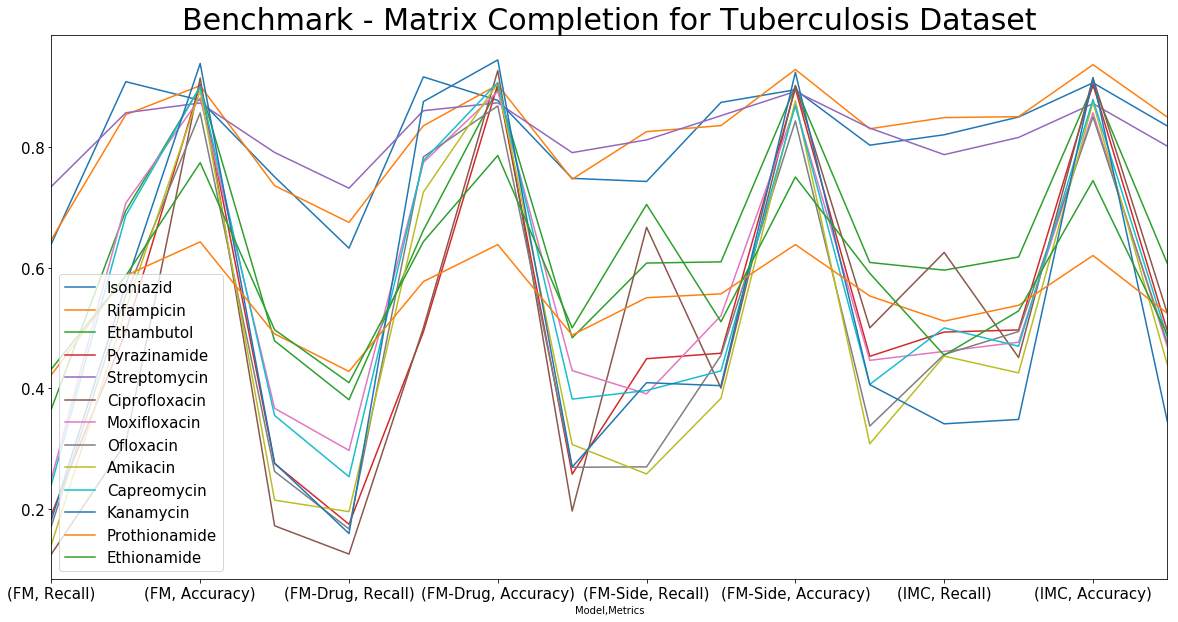

In [198]:
ax = drug_results.plot(kind='line', figsize = (20,10), use_index = True, \
                       fontsize = 15)
ax.legend(prop={'size': 15})
ax.set_title('Benchmark - Matrix Completion for Tuberculosis Dataset',fontsize= 30) 
fig = ax.get_figure()
fig.savefig('drugs.png')

In [18]:
# data
data = np.hstack( ( r1[5:].reshape((-1,4)) , r2[5:].reshape((-1,4)), \
                    r3[5:].reshape((-1,4)) , r4 ) ).T
data.shape

(16, 13)

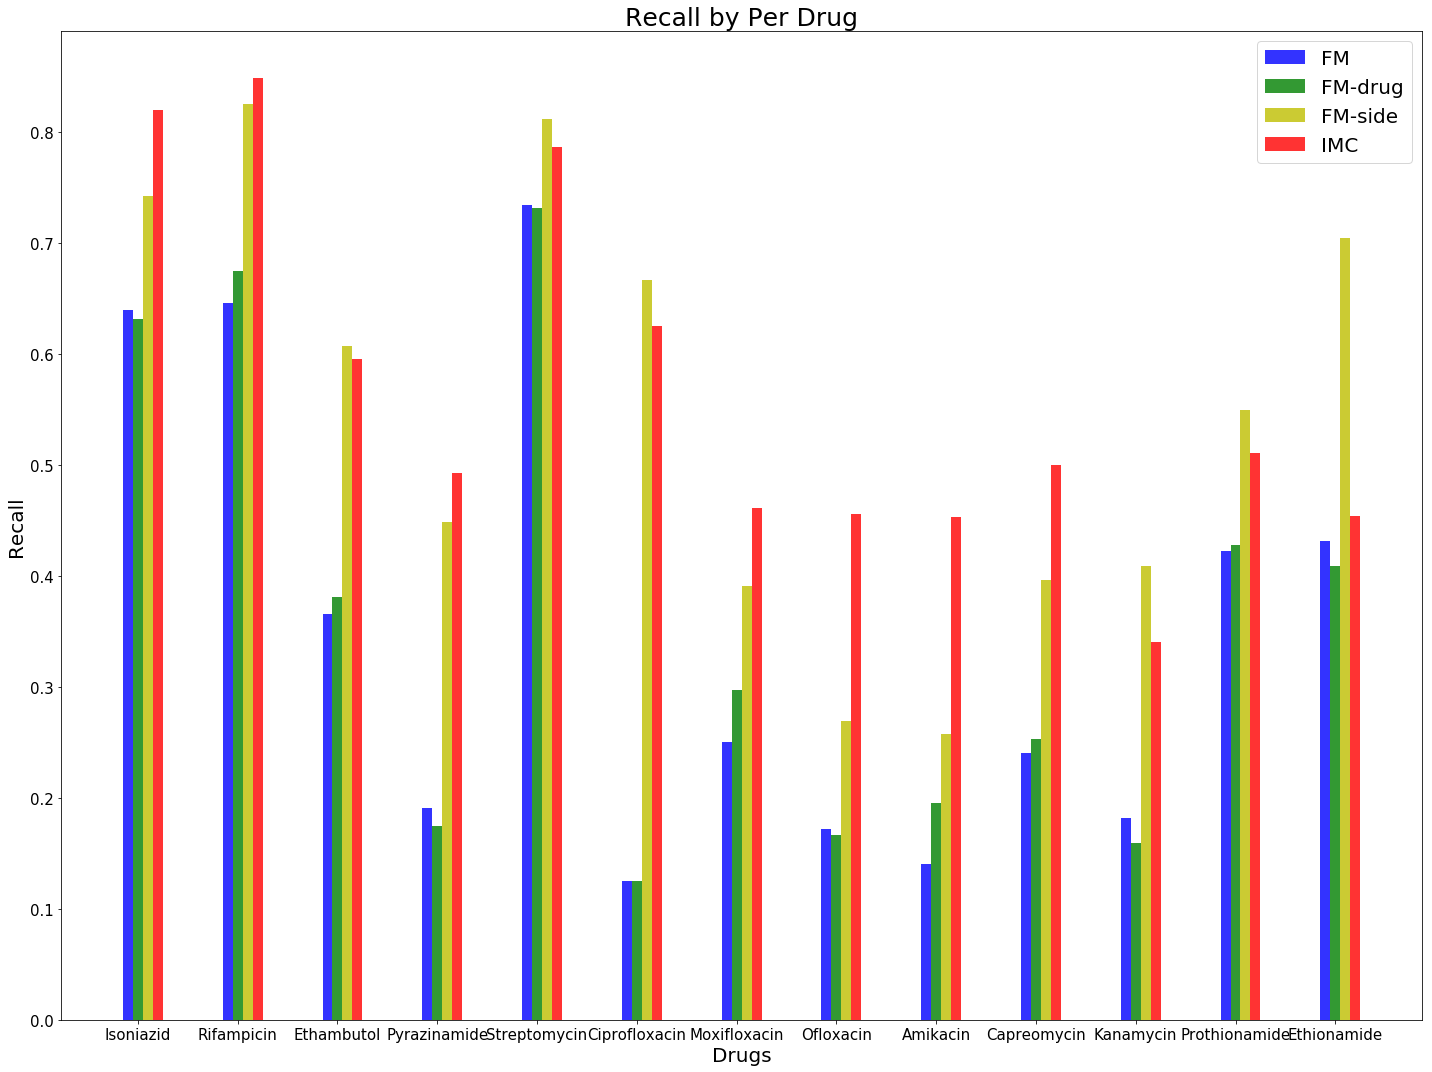

In [44]:
# data to plot
n_groups = len( drugs)
recall_fm = data[0,:]
recall_fm_drug = data[4,:]
recall_fm_side = data[8,:]
recall_imc = data[12,:]
 
# create plot

fig, ax = plt.subplots(figsize = (20,15))
index = np.arange(n_groups)
bar_width = 0.10
opacity = 0.8

 
rects1 = plt.bar(index, recall_fm, bar_width,
                 alpha=opacity,
                 color='b',
                 label='FM')
 
rects2 = plt.bar(index + bar_width, recall_fm_drug, bar_width,
                 alpha=opacity,
                 color='g',
                 label='FM-drug')

rects3 = plt.bar(index + 2*bar_width, recall_fm_side, bar_width,
                 alpha=opacity,
                 color='y',
                 label='FM-side')

rects4 = plt.bar(index + 3*bar_width, recall_imc, bar_width,
                 alpha=opacity,
                 color='r',
                 label='IMC')


plt.xlabel('Drugs', fontsize = 20)
plt.ylabel('Recall', fontsize = 20)
plt.title('Recall by Per Drug', fontsize = 25)
plt.xticks(index + bar_width, tuple(np.asarray(drugs)), fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 20)
plt.tight_layout()
plt.show()

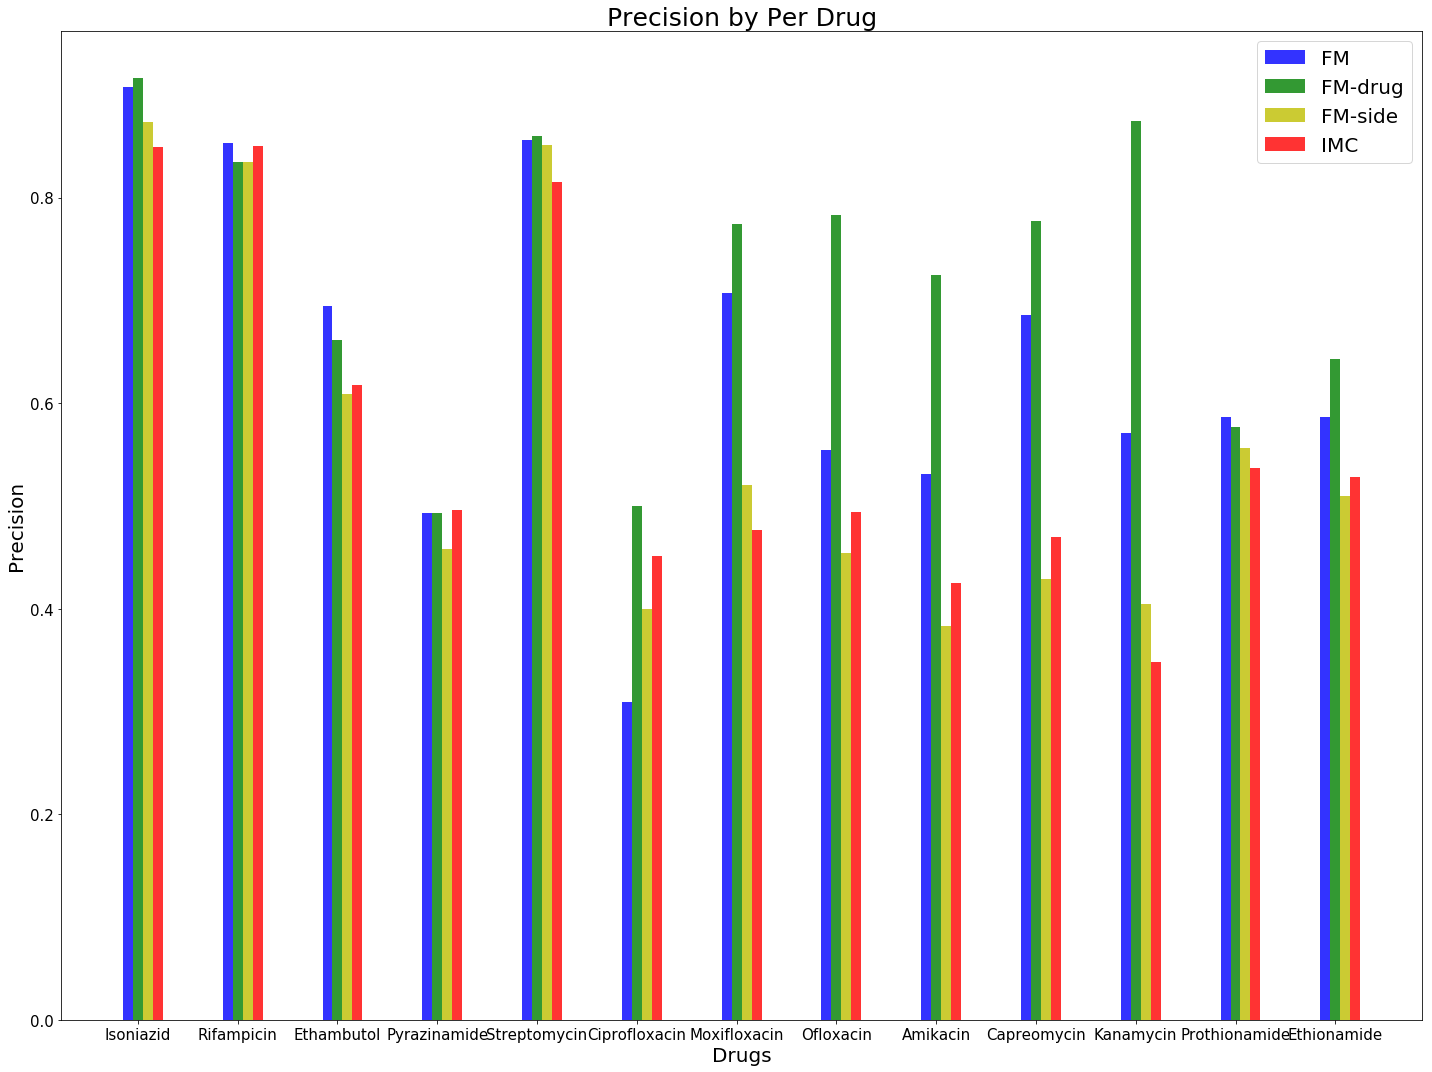

In [45]:
# data to plot
n_groups = len( drugs)
precision_fm = data[1,:]
precision_fm_drug = data[5,:]
precision_fm_side = data[9,:]
precision_imc = data[13,:]
 
# create plot

fig, ax = plt.subplots(figsize = (20,15))
index = np.arange(n_groups)
bar_width = 0.10
opacity = 0.8

 
rects1 = plt.bar(index, precision_fm, bar_width,
                 alpha=opacity,
                 color='b',
                 label='FM')
 
rects2 = plt.bar(index + bar_width, precision_fm_drug, bar_width,
                 alpha=opacity,
                 color='g',
                 label='FM-drug')

rects3 = plt.bar(index + 2*bar_width, precision_fm_side, bar_width,
                 alpha=opacity,
                 color='y',
                 label='FM-side')

rects4 = plt.bar(index + 3*bar_width, precision_imc, bar_width,
                 alpha=opacity,
                 color='r',
                 label='IMC')


plt.xlabel('Drugs', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)
plt.title('Precision by Per Drug', fontsize = 25)
plt.xticks(index + bar_width, tuple(np.asarray(drugs)), fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 20)
plt.tight_layout()
plt.show()

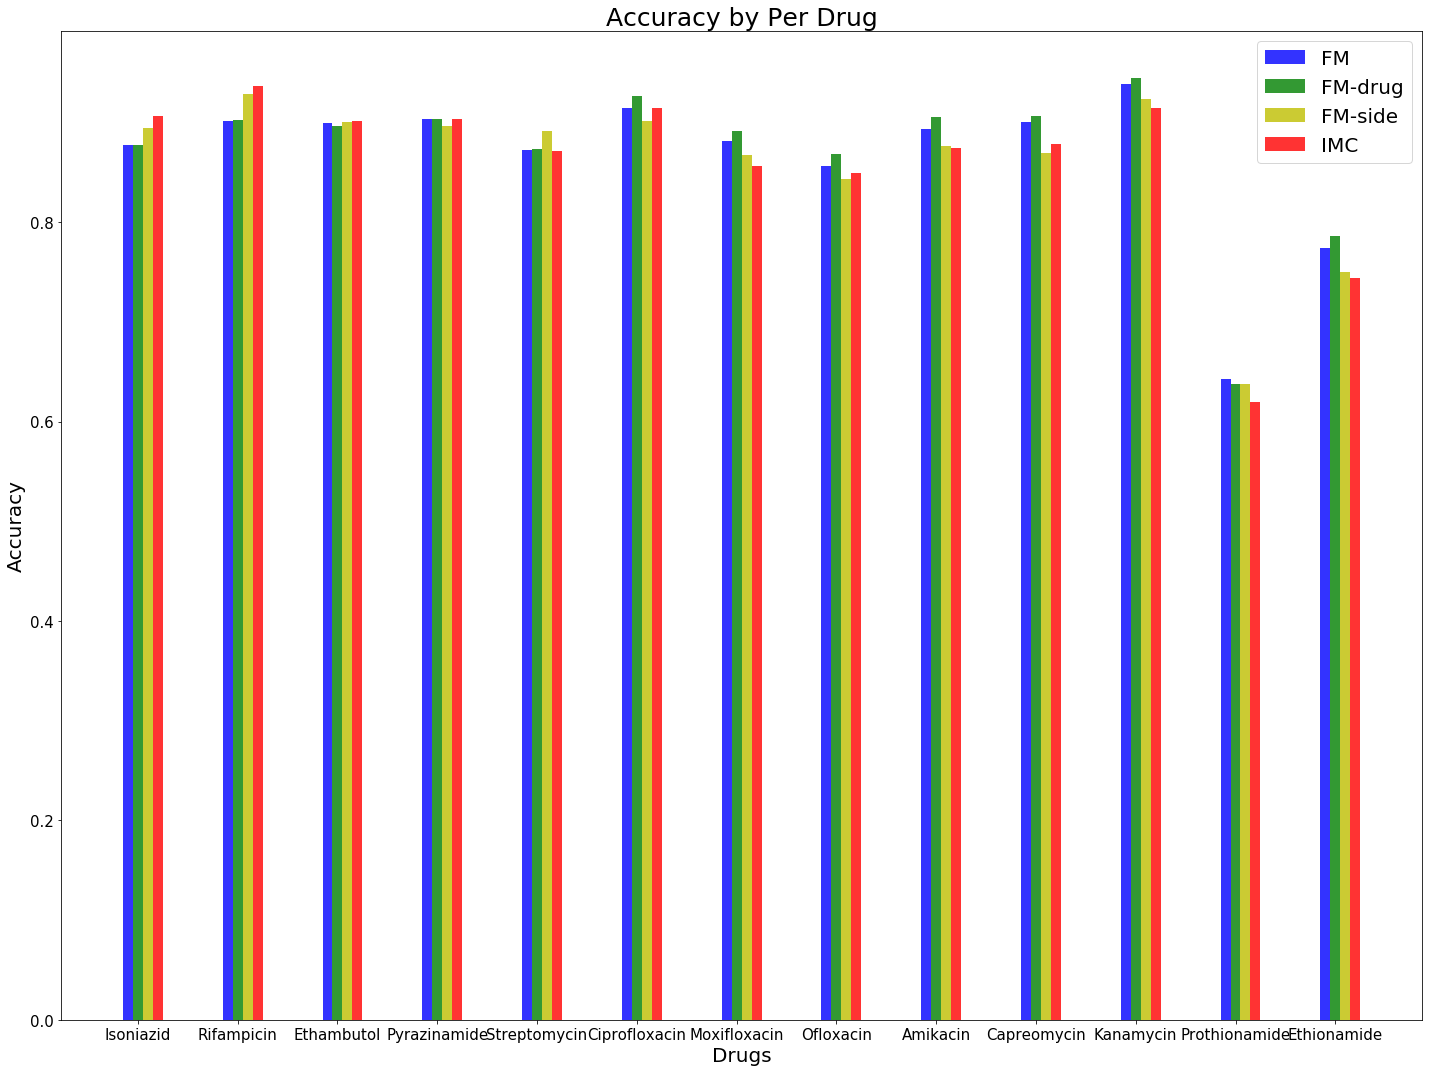

In [46]:
# data to plot
n_groups = len( drugs)
accuracy_fm = data[2,:]
accuracy_fm_drug = data[6,:]
accuracy_fm_side = data[10,:]
accuracy_imc = data[14,:]
 
# create plot

fig, ax = plt.subplots(figsize = (20,15))
index = np.arange(n_groups)
bar_width = 0.10
opacity = 0.8

 
rects1 = plt.bar(index, accuracy_fm, bar_width,
                 alpha=opacity,
                 color='b',
                 label='FM')
 
rects2 = plt.bar(index + bar_width, accuracy_fm_drug, bar_width,
                 alpha=opacity,
                 color='g',
                 label='FM-drug')

rects3 = plt.bar(index + 2*bar_width, accuracy_fm_side, bar_width,
                 alpha=opacity,
                 color='y',
                 label='FM-side')

rects4 = plt.bar(index + 3*bar_width, accuracy_imc, bar_width,
                 alpha=opacity,
                 color='r',
                 label='IMC')


plt.xlabel('Drugs', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.title('Accuracy by Per Drug', fontsize = 25)
plt.xticks(index + bar_width, tuple(np.asarray(drugs)), fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 20)
plt.tight_layout()
plt.show()

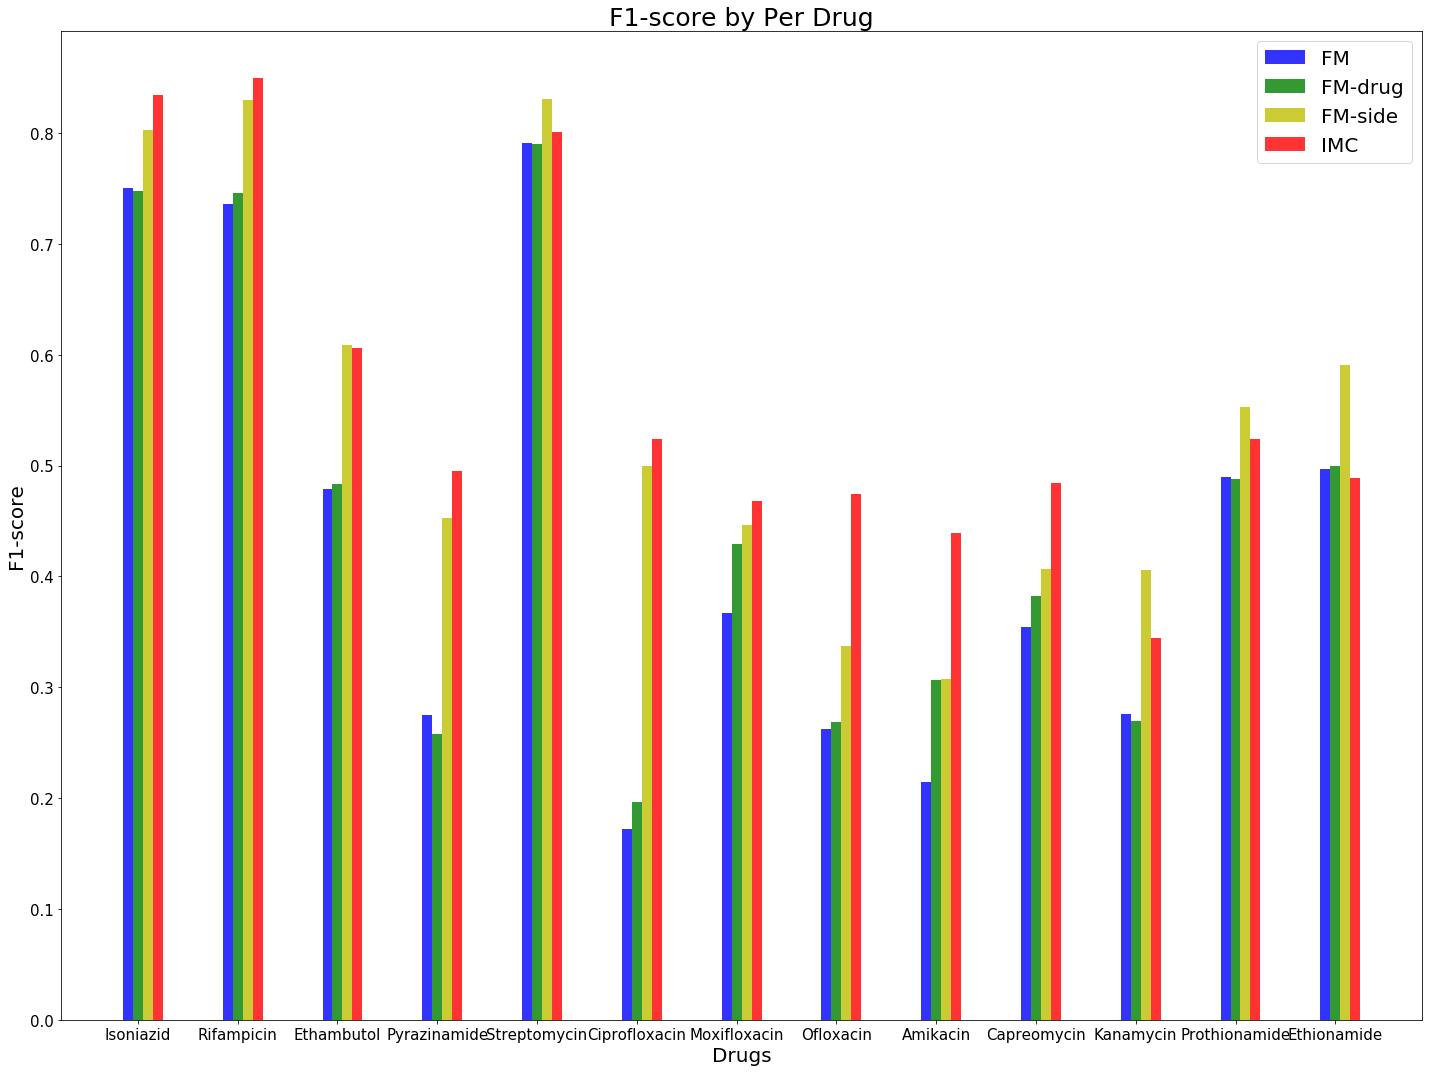

In [47]:
# data to plot
n_groups = len( drugs)
f1score_fm = data[3,:]
f1score_fm_drug = data[7,:]
f1score_fm_side = data[11,:]
f1score_imc = data[15,:]
 
# create plot

fig, ax = plt.subplots(figsize = (20,15))
index = np.arange(n_groups)
bar_width = 0.10
opacity = 0.8

 
rects1 = plt.bar(index, f1score_fm, bar_width,
                 alpha=opacity,
                 color='b',
                 label='FM')
 
rects2 = plt.bar(index + bar_width, f1score_fm_drug, bar_width,
                 alpha=opacity,
                 color='g',
                 label='FM-drug')

rects3 = plt.bar(index + 2*bar_width, f1score_fm_side, bar_width,
                 alpha=opacity,
                 color='y',
                 label='FM-side')

rects4 = plt.bar(index + 3*bar_width, f1score_imc, bar_width,
                 alpha=opacity,
                 color='r',
                 label='IMC')


plt.xlabel('Drugs', fontsize = 20)
plt.ylabel('F1-score', fontsize = 20)
plt.title('F1-score by Per Drug', fontsize = 25)
plt.xticks(index + bar_width, tuple(np.asarray(drugs)), fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 20)
plt.tight_layout()
plt.show()